# Open Policing Nashville Analysis
____________________________
### Thomas Possidente
__________________
<br>

The Nashville Police stop data used here comes from the Open Policing Project at Stanford (https://openpolicing.stanford.edu/).    
  
  
<br>
      

E. Pierson, C. Simoiu, J. Overgoor, S. Corbett-Davies, D. Jenson, A. Shoemaker, V. Ramachandran, P. Barghouty, C. Phillips, R. Shroff, and S. Goel. “A large-scale analysis of racial disparities in police stops across the United States”. Nature Human Behaviour, Vol. 4, 2020.

### Importing Packages

In [1]:
# Data analysis imports #
import pandas as pd
import numpy as np

# Plotting imports #
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Statistics imports #
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests
from scipy.stats import skew, levene

# Data Management/IO
import pickle

### Initializing plots and helper function

In [2]:
# Change text color in plots #
COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

In [3]:
# Helper Function #
def append_value(dict_obj, key, value):
    # Check if key exist in dict or not
    if key in dict_obj:
        # Key exist in dict.
        # Check if type of value of key is list or not
        if not isinstance(dict_obj[key], list):
            # If type is not list then make it list
            dict_obj[key] = [dict_obj[key]]
        # Append the value in list
        dict_obj[key].append(value)
    else:
        # As key is not in dict,
        # so, add key-value pair
        dict_obj[key] = value

### Load and look at data

In [4]:
# Read in data
data = pd.read_csv("../police_stops/tn_nashville_2020_04_01.csv")

# drop those rows with no date
data = data.dropna(subset=['date']) 

# create column for easy acces to year
data["year"] = [d[0:4] for d in data.date] 

c:\users\tom\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (6,8,15,16,17,22,23,24,25,29,30,31,32,33,35,36,37,38,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Check number of rows/cols
data.shape

(3092351, 43)

In [6]:
# Take a look at some data
data.iloc[0:5] 

,raw_row_number,date,time,location,lat,lng,precinct,reporting_area,zone,subject_age,...,raw_misd_state_citation_issued,raw_suspect_ethnicity,raw_driver_searched,raw_passenger_searched,raw_search_consent,raw_search_arrest,raw_search_warrant,raw_search_inventory,raw_search_plain_view,year
0,232947,2010-10-10,NaN,"DOMINICAN DR & ROSA L PARKS BLVD, NASHVILLE, T...",36.187925,-86.798519,6,4403.0,611,27.0,...,NaN,N,False,False,False,False,False,False,False,2010
1,237161,2010-10-10,10:00:00,"1122 LEBANON PIKE, NASHVILLE, TN, 37210",36.155521,-86.735902,5,9035.0,513,18.0,...,NaN,N,False,False,False,False,False,False,False,2010
2,232902,2010-10-10,10:00:00,"898 DAVIDSON DR, , TN, 37205",36.117420,-86.895593,1,5005.0,121,52.0,...,NaN,N,False,False,False,False,False,False,False,2010
3,233219,2010-10-10,22:00:00,"MURFREESBORO PIKE & NASHBORO BLVD, ANTIOCH, TN...",36.086799,-86.648581,3,8891.0,325,25.0,...,NaN,N,False,False,False,False,False,False,False,2010
4,232780,2010-10-10,01:00:00,"BUCHANAN ST, NORTH, TN, 37208",36.180038,-86.809109,NaN,NaN,NaN,21.0,...,NaN,N,True,True,False,False,False,False,False,2010


In [7]:
# Take a look at a single row of data
data.iloc[1]

raw_row_number                                                     237161
date                                                           2010-10-10
time                                                             10:00:00
location                          1122 LEBANON PIKE, NASHVILLE, TN, 37210
lat                                                               36.1555
lng                                                              -86.7359
precinct                                                                5
reporting_area                                                       9035
zone                                                                  513
subject_age                                                            18
subject_race                                                        white
subject_sex                                                          male
officer_id_hash                                                a983204b21
type                                  

### Plot population race demographics vs. stop race demographics

In [8]:
# Get number of stops for each race in 2019
races_noNaN = data["subject_race"].dropna() 
unique_races = np.unique(races_noNaN)
print(unique_races)
data_19 = data[data["year"]=="2019"]
race_dict = {r:sum(data_19.subject_race == r) for r in unique_races}


['asian/pacific islander' 'black' 'hispanic' 'other' 'unknown' 'white']


In [9]:
# Get ratio of stops for each race vs total # of stops in 2019
np.array(list(race_dict.values()))/sum(race_dict.values())*100


array([ 1.74365464, 35.26682135,  7.61442734,  0.05624692,  2.50298812,
       52.81586163])

In [10]:
# pop race dict based on stats from 2019 census:https: //www.census.gov/quickfacts/fact/table/nashvilledavidsonbalancetennessee/IPE120219
pop_race_dict = {"asian/pacific islander":3.8, "black":27.6, "hispanic":10.5, "white":63.5}

# new race dict rounded values from above cell
new_race_dict = {"asian/pacific islander":1.74, "black":35.27, "hispanic":7.61, "white":52.82}

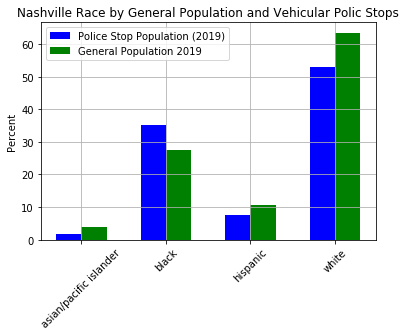

In [11]:
# Plot population race statistics #
x = np.arange(4)
ax1 = plt.subplot(1,1,1)
w = 0.3
plt.xticks(x + w /2, list(new_race_dict.keys()), rotation=45)
plt.grid()
race = ax1.bar(x, list(new_race_dict.values()), width=w, color='b', align='center', 
               label='Police Stop Population (2019)')
pop_race = ax1.bar(x + w, list(pop_race_dict.values()), width=w,color='g',align='center',
                  label='General Population 2019')
plt.ylabel('Percent')
plt.title("Nashville Race by General Population and Vehicular Polic Stops")

l = plt.legend()
for text in l.get_texts():
    text.set_color("black")
plt.show()

### Calculate and plot arrest/citation/warning rates per race per year

In [12]:
# Calculate arrest, citation, warning percentages for each year for each
# race/year with over 1000 stops

races = ["white", "black", "hispanic", "asian/pacific islander", "unknown", "other"] 
years = np.unique(data.year)
year_inds = np.arange(0,10,2)

arrest_dict = {"black":[], "white":[], "hispanic":[], "asian/pacific islander":[], 
               "unknown":[], "other":[]}
citation_dict = {"black":[], "white":[], "hispanic":[], "asian/pacific islander":[], 
               "unknown":[], "other":[]}
warning_dict = {"black":[], "white":[], "hispanic":[], "asian/pacific islander":[], 
               "unknown":[], "other":[]}
total_stops_dict = {"black":[], "white":[], "hispanic":[], "asian/pacific islander":[], 
               "unknown":[], "other":[]}

for race in races:
    for y in year_inds:
        # Get data for years and race in question
        data_new = data[(data["subject_race"]==race) & 
                        ((data["year"]==years[y])  | (data["year"]==years[y+1]))]
        total_stops = data_new.shape[0]
        if total_stops > 1000: # make sure over 1000 stops
            # Get rates of arrest/citation/search
            append_value(total_stops_dict, race, total_stops)
            arrest_percent = sum(data_new["outcome"]=="arrest") / total_stops
            append_value(arrest_dict, race, arrest_percent)
            citation_percent = sum(data_new["outcome"]=="citation") / total_stops
            append_value(citation_dict, race, citation_percent)
            warning_percent = sum(data_new["outcome"]=="warning") / total_stops
            append_value(warning_dict, race, warning_percent)
        else:
            append_value(total_stops_dict, race, total_stops)
            append_value(arrest_dict, race, np.nan)
            append_value(citation_dict, race, np.nan)
            append_value(warning_dict, race, np.nan)
            


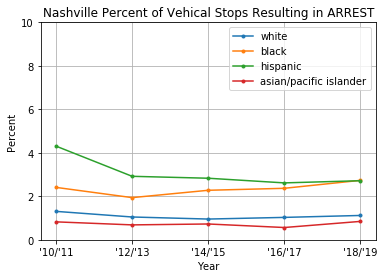

In [13]:
# Plot percentages of arrests per race per year #
x_yrs = ["'10/'11", "'12/'13", "'14/'15", "'16/'17", "'18/'19"]

plt.grid()
plt.plot(x_yrs, np.array(arrest_dict["white"])*100, marker=".", label="white")
plt.plot(x_yrs, np.array(arrest_dict["black"])*100, marker=".", label="black")
plt.plot(x_yrs, np.array(arrest_dict["hispanic"])*100, marker=".", label="hispanic")
plt.plot(x_yrs, np.array(arrest_dict["asian/pacific islander"])*100, marker=".", label="asian/pacific islander")

plt.ylim([0,10])
plt.legend()
plt.xlabel("Year")
plt.ylabel("Percent")
plt.title("Nashville Percent of Vehical Stops Resulting in ARREST")

l = plt.legend()
for text in l.get_texts():
    text.set_color("black")
    
plt.savefig('arrest_rates.png')

plt.show()

In [14]:
# Two sample proportional z-test for significance between rates of arrests
# in traffic stops between black, white, and hispanic people

print("Two sample proportional z-test for significance between rates of arrest\n")
for y in range(len(year_inds)):
    print(years[year_inds[y]] + ' - ' + str(int(years[year_inds[y]])+1))
    num_stops_black = total_stops_dict["black"][y]
    num_stops_white = total_stops_dict["white"][y]
    num_stops_hispanic = total_stops_dict["hispanic"][y]
    z,p = proportions_ztest([num_stops_black*arrest_dict["black"][y], 
                             num_stops_white*arrest_dict["white"][y]],
                            [num_stops_black,num_stops_white])
    print("black v. white: " +str(p))
    z,p = proportions_ztest([num_stops_black*arrest_dict["hispanic"][y], 
                             num_stops_white*arrest_dict["white"][y]],
                            [num_stops_black,num_stops_white])
    print("hispanic v. white: " +str(p))
    print()
    print("no need for formal p-value correction for multiple tests because of extreme p-values")

Two sample proportional z-test for significance between rates of arrest

2010 - 2011
black v. white: 6.989196097346373e-242
hispanic v. white: 0.0

no need for formal p-value correction for multiple tests because of extreme p-values
2012 - 2013
black v. white: 2.27081007238217e-239
hispanic v. white: 0.0

no need for formal p-value correction for multiple tests because of extreme p-values
2014 - 2015
black v. white: 0.0
hispanic v. white: 0.0

no need for formal p-value correction for multiple tests because of extreme p-values
2016 - 2017
black v. white: 5.304167380395478e-301
hispanic v. white: 0.0

no need for formal p-value correction for multiple tests because of extreme p-values
2018 - 2019
black v. white: 2.546317130048254e-156
hispanic v. white: 9.455128151189907e-154

no need for formal p-value correction for multiple tests because of extreme p-values


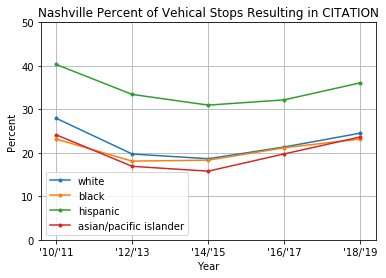

In [15]:
# Plot percentages of citations per race per year #

x_yrs = ["'10/'11", "'12/'13", "'14/'15", "'16/'17", "'18/'19"]

plt.grid()
plt.plot(x_yrs, np.array(citation_dict["white"])*100, marker=".", label="white")
plt.plot(x_yrs, np.array(citation_dict["black"])*100, marker=".", label="black")
plt.plot(x_yrs, np.array(citation_dict["hispanic"])*100, marker=".", label="hispanic")
plt.plot(x_yrs, np.array(citation_dict["asian/pacific islander"])*100, marker=".", label="asian/pacific islander")

plt.ylim([0, 50])
plt.legend()
plt.xlabel("Year")
plt.ylabel("Percent")
plt.title("Nashville Percent of Vehical Stops Resulting in CITATION")

l = plt.legend()
for text in l.get_texts():
    text.set_color("black")
    
plt.savefig('citation_rates.png')

plt.show()

In [16]:
# Two sample proportional z-test for significance between rates of citation
# in traffic stops between black, white, and hispanic people

print("Two sample proportional z-test for significance between rates of citation\n")
for y in range(len(year_inds)):
    print(years[year_inds[y]] + ' - ' + str(int(years[year_inds[y]])+1))
    num_stops_black = total_stops_dict["black"][y]
    num_stops_white = total_stops_dict["white"][y]
    num_stops_hispanic = total_stops_dict["hispanic"][y]
    z,p = proportions_ztest([num_stops_black*citation_dict["black"][y], 
                             num_stops_white*citation_dict["white"][y]],
                            [num_stops_black,num_stops_white])
    print("black v. white: " +str(p))
    z,p = proportions_ztest([num_stops_black*citation_dict["hispanic"][y], 
                             num_stops_white*citation_dict["white"][y]],
                            [num_stops_black,num_stops_white])
    print("hispanic v. white: " +str(p))
    print()
    print("no need for formal p-value correction for multiple tests because of extreme p-values")

Two sample proportional z-test for significance between rates of citation

2010 - 2011
black v. white: 0.0
hispanic v. white: 0.0

no need for formal p-value correction for multiple tests because of extreme p-values
2012 - 2013
black v. white: 7.716081179388888e-75
hispanic v. white: 0.0

no need for formal p-value correction for multiple tests because of extreme p-values
2014 - 2015
black v. white: 0.0004477145745832531
hispanic v. white: 0.0

no need for formal p-value correction for multiple tests because of extreme p-values
2016 - 2017
black v. white: 0.12686152287700703
hispanic v. white: 0.0

no need for formal p-value correction for multiple tests because of extreme p-values
2018 - 2019
black v. white: 9.124462390133339e-12
hispanic v. white: 0.0

no need for formal p-value correction for multiple tests because of extreme p-values


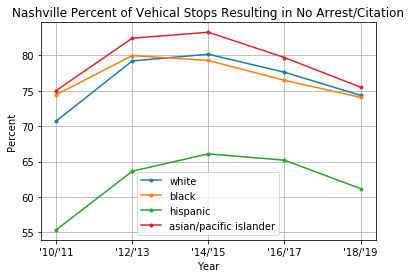

In [17]:
# Plot percentages of warnings per race per year #

plt.grid()
plt.plot(x_yrs, np.array(warning_dict["white"])*100, marker=".", label="white")
plt.plot(x_yrs, np.array(warning_dict["black"])*100, marker=".", label="black")
plt.plot(x_yrs, np.array(warning_dict["hispanic"])*100, marker=".", label="hispanic")
plt.plot(x_yrs, np.array(warning_dict["asian/pacific islander"])*100, marker=".", label="asian/pacific islander")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Percent")
plt.title("Nashville Percent of Vehical Stops Resulting in No Arrest/Citation")

l = plt.legend()
for text in l.get_texts():
    text.set_color("black")
plt.show()

### Calculate and plot search and found rates per race per year

In [18]:
# Get search percentages and contraband found percentages per race per year #

year_inds = np.arange(0,10,2)

searches_dict = {"black":[], "white":[], "hispanic":[], "asian/pacific islander":[], 
               "unknown":[], "other":[]}
found_dict = {"black":[], "white":[], "hispanic":[], "asian/pacific islander":[], 
               "unknown":[], "other":[]}

for race in races:
    for y in year_inds:
        # Get data for race, year, and search status in question
        data_new = data[((data["subject_race"]==race) & (data["search_conducted"]==True)) & 
                        ((data["year"]==years[y]) | (data["year"]==years[y+1]))]
        searches_count = data_new.shape[0]
        if searches_count > 1000: # make sure over 1000 stops 
            # Get search count and found rate
            append_value(searches_dict, race, searches_count)
            append_value(found_dict, race, sum(data_new["contraband_found"]==True)/searches_count)
        else:
            append_value(searches_dict, race, searches_count)
            append_value(found_dict, race, np.nan)


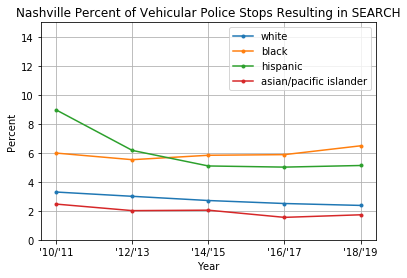

In [19]:
# Plot search percentages per race per year #
plt.grid()
x_yrs = ["'10/'11", "'12/'13", "'14/'15", "'16/'17", "'18/'19"]
plt.plot(x_yrs, (np.array(searches_dict["white"])/np.array(total_stops_dict["white"]))*100, 
         marker=".", label="white")
plt.plot(x_yrs, (np.array(searches_dict["black"])/np.array(total_stops_dict["black"]))*100, 
         marker=".", label="black")
plt.plot(x_yrs, (np.array(searches_dict["hispanic"])/np.array(total_stops_dict["hispanic"]))*100, 
         marker=".", label="hispanic")
plt.plot(x_yrs, (np.array(searches_dict["asian/pacific islander"])/np.array(total_stops_dict["asian/pacific islander"]))*100, 
         marker=".", label="asian/pacific islander")

plt.ylim([0, 15])
plt.legend()
plt.xlabel("Year")
plt.ylabel("Percent")
plt.title("Nashville Percent of Vehicular Police Stops Resulting in SEARCH")

# Make legend text black
l = plt.legend() 
for text in l.get_texts():
    text.set_color("black")
    
plt.savefig('search_rates.png')
plt.show()


[17.9196293  19.78157991 21.26466982 24.41498715 28.15779949]
[17.64045644 20.51740001 22.31906708 25.28597231 28.39861751]


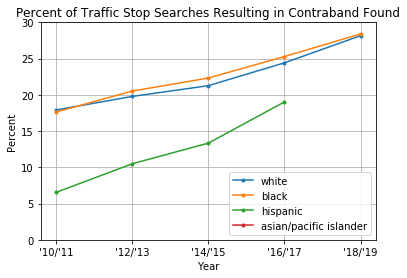

In [20]:
# Plot percentages of contraband found per race per year #
x_yrs = ["'10/'11", "'12/'13", "'14/'15", "'16/'17", "'18/'19"]

plt.grid()
plt.plot(x_yrs, np.array(found_dict["white"])*100, marker=".", label="white")
plt.plot(x_yrs, np.array(found_dict["black"])*100, marker=".", label="black")
plt.plot(x_yrs, np.array(found_dict["hispanic"])*100, marker=".", label="hispanic")
plt.plot(x_yrs, np.array(found_dict["asian/pacific islander"])*100, marker=".", label="asian/pacific islander")
print( np.array(found_dict["white"])*100)
print(np.array(found_dict["black"])*100)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Percent")
plt.title("Percent of Traffic Stop Searches Resulting in Contraband Found")
plt.ylim([0,30])

l = plt.legend()
for text in l.get_texts():
    text.set_color("black")
    
plt.savefig('found_rates.png')

plt.show()



In [21]:
# Two sample proportional z-test for significance between rates of contraband found
# from searches 

pvals_wb = []
print("Two sample proportional z-test for significance between rates of contraband found from searches on white vs black individuals")
for y in range(len(year_inds)):
    print(years[year_inds[y]] + ' - ' + str(int(years[year_inds[y]])+1))
    num_searches_black = searches_dict["black"][y]
    num_searches_white = searches_dict["white"][y]
    z,p = proportions_ztest([num_searches_black*found_dict["black"][y], 
                             num_searches_white*found_dict["white"][y]],
                            [num_searches_black,num_searches_white])
    pvals_wb.append(p)
    print(p)
    print(z)
    print()
    
pvals_wh = []
print("Two sample proportional z-test for significance between rates of contraband found from searches on white vs hispanic individuals")
for y in range(len(year_inds)):
    print(years[year_inds[y]] + ' - ' + str(int(years[year_inds[y]])+1))
    num_searches_hispanic = searches_dict["hispanic"][y]
    num_searches_white = searches_dict["white"][y]
    z,p = proportions_ztest([num_searches_hispanic*found_dict["hispanic"][y], 
                             num_searches_white*found_dict["white"][y]],
                            [num_searches_hispanic,num_searches_white])
    pvals_wh.append(p)
    print(p)
    print(z)
    print()

Two sample proportional z-test for significance between rates of contraband found from searches on white vs black individuals
2010 - 2011
0.540248874462008
-0.612436688060242

2012 - 2013
0.10381757381374196
1.6266212005157263

2014 - 2015
0.03588586438923462
2.098218315577773

2016 - 2017
0.17599966366239883
1.3531752075997276

2018 - 2019
0.8203385506900662
0.22710955971029442

Two sample proportional z-test for significance between rates of contraband found from searches on white vs hispanic individuals
2010 - 2011
3.6307721109966996e-55
-15.644346510477963

2012 - 2013
6.163159342553101e-29
-11.163340196067907

2014 - 2015
8.197560263092233e-17
-8.328351805411582

2016 - 2017
2.771991747164464e-06
-4.687029388209282

2018 - 2019
nan
nan



c:\users\tom\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
c:\users\tom\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
c:\users\tom\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [24]:
# The only p-value with ambiguous result after correcting for multiple testing is
# comparison between 2014/15 black and white rates of contraband found. So, explicitly 
# use bonferonni method to check significance
multipletests([pvals_wb[2], pvals_wh[2]], 0.05, 'bonferroni')[3]

0.025

In [26]:
# Make sure no searches conducted had missing data for search basis
data[(data["search_conducted"]==True) & (data["search_basis"]==np.nan)].shape[0]

0

### Plot basis of search per race per year

In [27]:
# Get statistics on search basis per race per year #

search_bases = ['consent', 'other', 'plain view', 'probable cause']

basis_dicts = [{"black":[], "white":[], "hispanic":[], "asian/pacific islander":[], 
               "unknown":[], "other":[]},
                {"black":[], "white":[], "hispanic":[], "asian/pacific islander":[], 
               "unknown":[], "other":[]},
                {"black":[], "white":[], "hispanic":[], "asian/pacific islander":[], 
               "unknown":[], "other":[]},
                {"black":[], "white":[], "hispanic":[], "asian/pacific islander":[], 
               "unknown":[], "other":[]}]


for race in races:
    for y in year_inds:
        # Get data for race, year, and search status in question
        new_data = data[(data["subject_race"]==race) & (data["search_conducted"]==True) & 
                       ((data["year"]==years[y]) | (data["year"]==years[y+1]))]
        searches_count = new_data.shape[0]
        if searches_count > 1000: # make sure over 1000 stops
            for b in range(len(basis_dicts)):
                # get rate of searches with this basis
                append_value(basis_dicts[b], race, 
                            sum(new_data["search_basis"]==search_bases[b])/searches_count)
        else:
            for b in range(len(basis_dicts)):
                append_value(basis_dicts[b], race, np.nan)


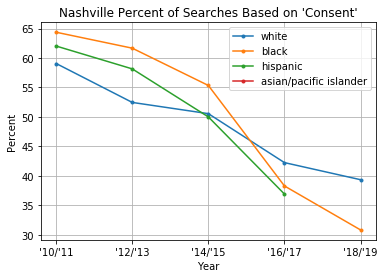

In [28]:
# Plot percentages of searches based on consent per race per year #

plt.grid()
plt.plot(x_yrs, np.array(basis_dicts[0]["white"])*100, marker=".", label="white")
plt.plot(x_yrs, np.array(basis_dicts[0]["black"])*100, marker=".", label="black")
plt.plot(x_yrs, np.array(basis_dicts[0]["hispanic"])*100, marker=".", label="hispanic")
plt.plot(x_yrs, np.array(basis_dicts[0]["asian/pacific islander"])*100, marker=".", label="asian/pacific islander")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Percent")
plt.title("Nashville Percent of Searches Based on 'Consent'")

l = plt.legend()
for text in l.get_texts():
    text.set_color("black")
plt.show()

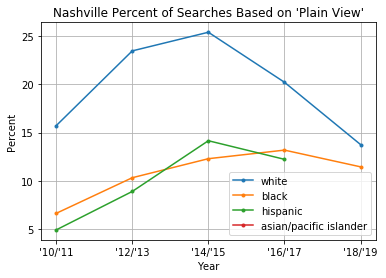

In [29]:
# Plot percentages of searches based on Plain View per race per year #

plt.grid()
plt.plot(x_yrs, np.array(basis_dicts[2]["white"])*100, marker=".", label="white")
plt.plot(x_yrs, np.array(basis_dicts[2]["black"])*100, marker=".", label="black")
plt.plot(x_yrs, np.array(basis_dicts[2]["hispanic"])*100, marker=".", label="hispanic")
plt.plot(x_yrs, np.array(basis_dicts[2]["asian/pacific islander"])*100, marker=".", label="asian/pacific islander")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Percent")
plt.title("Nashville Percent of Searches Based on 'Plain View'")

l = plt.legend()
for text in l.get_texts():
    text.set_color("black")
plt.show()

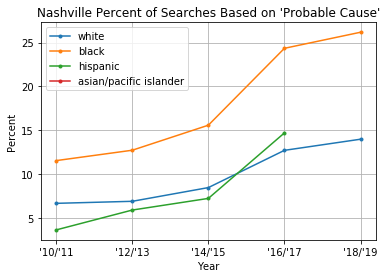

In [30]:
# Plot percentages of searches based on Probable Cause per race per year #

plt.grid()
plt.plot(x_yrs, np.array(basis_dicts[3]["white"])*100, marker=".", label="white")
plt.plot(x_yrs, np.array(basis_dicts[3]["black"])*100, marker=".", label="black")
plt.plot(x_yrs, np.array(basis_dicts[3]["hispanic"])*100, marker=".", label="hispanic")
plt.plot(x_yrs, np.array(basis_dicts[3]["asian/pacific islander"])*100, marker=".", label="asian/pacific islander")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Percent")
plt.title("Nashville Percent of Searches Based on 'Probable Cause'")

l = plt.legend()
for text in l.get_texts():
    text.set_color("black")
plt.show()

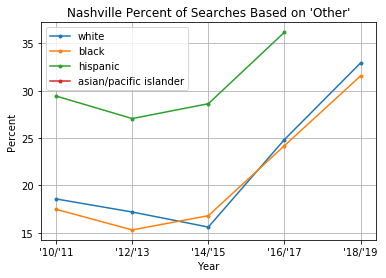

In [31]:
# Plot percentages of searches based on Other per race per year #

plt.grid()
plt.plot(x_yrs, np.array(basis_dicts[1]["white"])*100, marker=".", label="white")
plt.plot(x_yrs, np.array(basis_dicts[1]["black"])*100, marker=".", label="black")
plt.plot(x_yrs, np.array(basis_dicts[1]["hispanic"])*100, marker=".", label="hispanic")
plt.plot(x_yrs, np.array(basis_dicts[1]["asian/pacific islander"])*100, marker=".", label="asian/pacific islander")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Percent")
plt.title("Nashville Percent of Searches Based on 'Other'")

l = plt.legend()
for text in l.get_texts():
    text.set_color("black")
plt.show()

In [32]:
# make sure basis percents add up to 100% #

races_mod = ["white", "black", "hispanic"] # only these races had enough data for this analysis
for r in races_mod:
    for y in range(len(year_inds)):
        perc_count = 0
        for d in basis_dicts:
            if (np.isnan(d[r][y])):
                pass
            else:
                perc_count += d[r][y]
        print(perc_count)

print("Final 0 is because hispanic does not have enough 2018/19 data to be analyzed")

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0
Final 0 is because hispanic does not have enough 2018/19 data to be analyzed


### Analyze reason given for stop

In [28]:
# Get statistics on reason for stop 
print(data["reason_for_stop"].shape) # number of rows
print(data["reason_for_stop"].dropna().shape) # number of rows with reason for stop given
stop_reasons = np.unique(data["reason_for_stop"].dropna()) # drop rows without reason for stop
print(stop_reasons) # see all reasons for stop

(3092351,)
(3084331,)
['child restraint' 'investigative stop' 'moving traffic violation'
 'parking violation' 'registration' 'safety violation'
 'seatbelt violation' 'vehicle equipment violation']


In [33]:
# Get percentages on reason for stopper year per race #

year_inds = np.arange(0,10,2)

reason_count_dict = {"black":[], "white":[], "hispanic":[], "asian/pacific islander":[], 
               "unknown":[], "other":[]}
reason_percs_dict = {"black":[], "white":[], "hispanic":[], "asian/pacific islander":[], 
               "unknown":[], "other":[]}

for y in year_inds:
    for r in races:
        # Get data for years and race in question
        data_new = data[((data["year"] == years[y]) | 
                        (data["year"] == years[y+1])) & 
                        (data['subject_race'] == r)] 
        num_stops = data_new.shape[0]
        if num_stops >= 1000: # make sure over 1000 stops
            reason_counts = data_new["reason_for_stop"].value_counts()
            reason_percs = reason_counts / num_stops
            append_value(reason_percs_dict, r, reason_percs.to_dict())
            append_value(reason_count_dict, r, reason_counts.to_dict())
        else:
            append_value(reason_percs_dict, r, np.nan)
            append_value(reason_count_dict, r, np.nan)

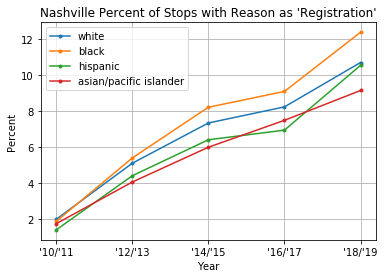

In [34]:
# Plot percent of stops with reason as Registration per race per year #
plt.grid()
plt.plot(x_yrs, np.array([n["registration"] for n in reason_percs_dict["white"]])*100, marker=".", label="white")
plt.plot(x_yrs, np.array([n["registration"] for n in reason_percs_dict["black"]])*100, marker=".", label="black")
plt.plot(x_yrs, np.array([n["registration"] for n in reason_percs_dict["hispanic"]])*100, marker=".", label="hispanic")
plt.plot(x_yrs, np.array([n["registration"] for n in reason_percs_dict["asian/pacific islander"]])*100, marker=".", label="asian/pacific islander")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Percent")
plt.title("Nashville Percent of Stops with Reason as 'Registration'")

l = plt.legend()
for text in l.get_texts():
    text.set_color("black")
plt.show()

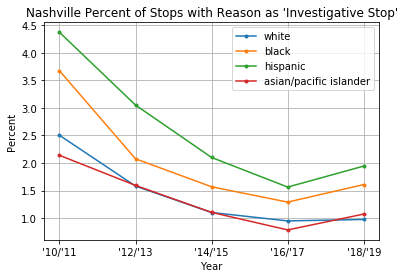

In [35]:
# Plot percent of stops with reason as Investigative Stop per race per year #

plt.grid()
plt.plot(x_yrs, np.array([n["investigative stop"] for n in reason_percs_dict["white"]])*100, marker=".", label="white")
plt.plot(x_yrs, np.array([n["investigative stop"] for n in reason_percs_dict["black"]])*100, marker=".", label="black")
plt.plot(x_yrs, np.array([n["investigative stop"] for n in reason_percs_dict["hispanic"]])*100, marker=".", label="hispanic")
plt.plot(x_yrs, np.array([n["investigative stop"] for n in reason_percs_dict["asian/pacific islander"]])*100, marker=".", label="asian/pacific islander")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Percent")
plt.title("Nashville Percent of Stops with Reason as 'Investigative Stop'")

l = plt.legend()
for text in l.get_texts():
    text.set_color("black")
plt.show()

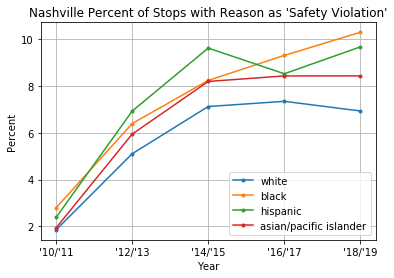

In [36]:
# Plot percent of stops with reason as Safety Violation per race per year #

plt.grid()
plt.plot(x_yrs, np.array([n["safety violation"] for n in reason_percs_dict["white"]])*100, marker=".", label="white")
plt.plot(x_yrs, np.array([n["safety violation"] for n in reason_percs_dict["black"]])*100, marker=".", label="black")
plt.plot(x_yrs, np.array([n["safety violation"] for n in reason_percs_dict["hispanic"]])*100, marker=".", label="hispanic")
plt.plot(x_yrs, np.array([n["safety violation"] for n in reason_percs_dict["asian/pacific islander"]])*100, marker=".", label="asian/pacific islander")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Percent")
plt.title("Nashville Percent of Stops with Reason as 'Safety Violation'")

l = plt.legend()
for text in l.get_texts():
    text.set_color("black")
plt.show()

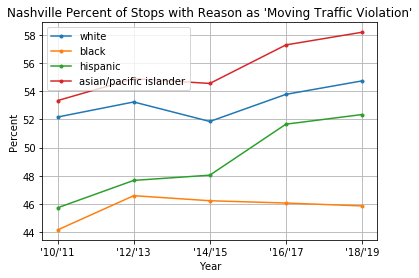

In [37]:
# Plot percent of stops with reason as Moving Traffic Violation per race per year #

plt.grid()
plt.plot(x_yrs, np.array([n["moving traffic violation"] for n in reason_percs_dict["white"]])*100, marker=".", label="white")
plt.plot(x_yrs, np.array([n["moving traffic violation"] for n in reason_percs_dict["black"]])*100, marker=".", label="black")
plt.plot(x_yrs, np.array([n["moving traffic violation"] for n in reason_percs_dict["hispanic"]])*100, marker=".", label="hispanic")
plt.plot(x_yrs, np.array([n["moving traffic violation"] for n in reason_percs_dict["asian/pacific islander"]])*100, marker=".", label="asian/pacific islander")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Percent")
plt.title("Nashville Percent of Stops with Reason as 'Moving Traffic Violation'")

l = plt.legend()
for text in l.get_texts():
    text.set_color("black")
plt.show()

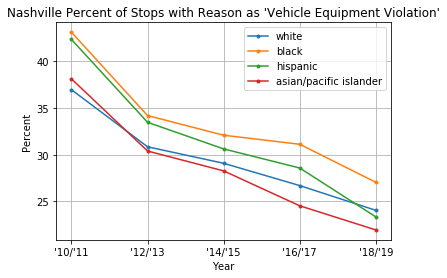

In [38]:
# Plot percent of stops with reason as Vehicle Equipment Violation per race per year #

plt.grid()
plt.plot(x_yrs, np.array([n["vehicle equipment violation"] for n in reason_percs_dict["white"]])*100, marker=".", label="white")
plt.plot(x_yrs, np.array([n["vehicle equipment violation"] for n in reason_percs_dict["black"]])*100, marker=".", label="black")
plt.plot(x_yrs, np.array([n["vehicle equipment violation"] for n in reason_percs_dict["hispanic"]])*100, marker=".", label="hispanic")
plt.plot(x_yrs, np.array([n["vehicle equipment violation"] for n in reason_percs_dict["asian/pacific islander"]])*100, marker=".", label="asian/pacific islander")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Percent")
plt.title("Nashville Percent of Stops with Reason as 'Vehicle Equipment Violation'")

l = plt.legend()
for text in l.get_texts():
    text.set_color("black")
plt.show()

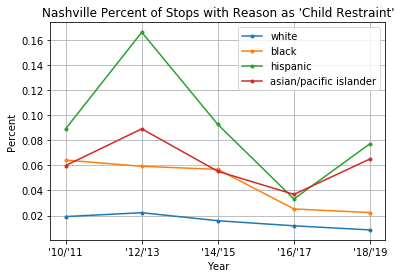

In [39]:
# Plot percent of stops with reason as Child Restraint per race per year #

plt.grid()
plt.plot(x_yrs, np.array([n["child restraint"] for n in reason_percs_dict["white"]])*100, marker=".", label="white")
plt.plot(x_yrs, np.array([n["child restraint"] for n in reason_percs_dict["black"]])*100, marker=".", label="black")
plt.plot(x_yrs, np.array([n["child restraint"] for n in reason_percs_dict["hispanic"]])*100, marker=".", label="hispanic")
plt.plot(x_yrs, np.array([n["child restraint"] for n in reason_percs_dict["asian/pacific islander"]])*100, marker=".", label="asian/pacific islander")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Percent")
plt.title("Nashville Percent of Stops with Reason as 'Child Restraint'")

l = plt.legend()
for text in l.get_texts():
    text.set_color("black")
plt.show()

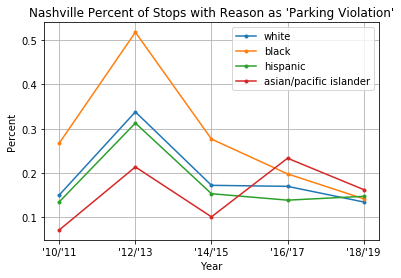

In [40]:
# Plot percent of stops with reason as Parking Violation per race per year #

plt.grid()
plt.plot(x_yrs, np.array([n["parking violation"] for n in reason_percs_dict["white"]])*100, marker=".", label="white")
plt.plot(x_yrs, np.array([n["parking violation"] for n in reason_percs_dict["black"]])*100, marker=".", label="black")
plt.plot(x_yrs, np.array([n["parking violation"] for n in reason_percs_dict["hispanic"]])*100, marker=".", label="hispanic")
plt.plot(x_yrs, np.array([n["parking violation"] for n in reason_percs_dict["asian/pacific islander"]])*100, marker=".", label="asian/pacific islander")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Percent")
plt.title("Nashville Percent of Stops with Reason as 'Parking Violation'")

l = plt.legend()
for text in l.get_texts():
    text.set_color("black")
plt.show()

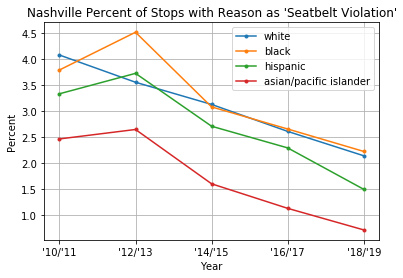

In [41]:
# Plot percent of stops with reason as Seatbelt Violation per race per year #

plt.grid()
plt.plot(x_yrs, np.array([n["seatbelt violation"] for n in reason_percs_dict["white"]])*100, marker=".", label="white")
plt.plot(x_yrs, np.array([n["seatbelt violation"] for n in reason_percs_dict["black"]])*100, marker=".", label="black")
plt.plot(x_yrs, np.array([n["seatbelt violation"] for n in reason_percs_dict["hispanic"]])*100, marker=".", label="hispanic")
plt.plot(x_yrs, np.array([n["seatbelt violation"] for n in reason_percs_dict["asian/pacific islander"]])*100, marker=".", label="asian/pacific islander")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Percent")
plt.title("Nashville Percent of Stops with Reason as 'Seatbelt Violation'")

l = plt.legend()
for text in l.get_texts():
    text.set_color("black")
plt.show()

### Individual offiver analysis

In [75]:
# Officer Hash Analysis #

# Get race counts for each officer
unique_cops = np.unique(data.officer_id_hash.dropna())
num_cops = len(unique_cops)
print(num_cops)

data_dropna = data.dropna(subset=["officer_id_hash"])

for c in unique_cops:
    # get data on stops for given officer
    data_new = data_dropna[data_dropna["officer_id_hash"] == c]
    # get race data on each stop for this officer
    race_dict = data_new["subject_race"].value_counts().to_dict()



2294


In [46]:
# Get cops with over 50 stops of each black, white, and hispanic subjects #
print("Total unique cops: " + str(len(cop_race_stop_counts)))

thresh = 50

# initialize storage variables
over_thresh_cop_hashes = []
lowest_count = [] 

for n in range(len(cop_race_stop_counts)):
    if (('black' in list(cop_race_stop_counts.values())[n]) & 
        ('white' in list(cop_race_stop_counts.values())[n]) & 
        ('hispanic' in list(cop_race_stop_counts.values())[n])):
        black_stops = list(cop_race_stop_counts.values())[n]["black"]
        white_stops = list(cop_race_stop_counts.values())[n]["white"]
        hisp_stops = list(cop_race_stop_counts.values())[n]["hispanic"]
        if ((black_stops >= thresh) & (white_stops >= thresh) & (hisp_stops >= thresh)):
            # Get cop hashes above threshold for for each race
            over_thresh_cop_hashes.append(list(cop_race_stop_counts.keys())[n])
            # Get lowest stop count out of 3 races
            lowest_count.append(min(black_stops, white_stops, hisp_stops)) 
            
print("Number of cops with over " + str(thresh) + 
      " stops each of black, white, and hispanic subjects: " +
     str(len(over_thresh_cop_hashes)))

Total unique cops: 2294
Number of cops with over 50 stops each of black, white, and hispanic subjects: 804


In [59]:
# For each cop with over 50 stops for each race, take only x number of stops where 
# x is the lowest number of stops out of the 3 races looked at. This ensures
# even accuracy in rate estimation across races. Then calc rates of search, arrest, citation

cop_race_stop_counts = {'black':[], 'hispanic':[], 'white':[]}
cop_race_search_rates = {'black':[], 'hispanic':[], 'white':[]}
cop_race_arrest_rates = {'black':[], 'hispanic':[], 'white':[]}
cop_race_citation_rates = {'black':[], 'hispanic':[], 'white':[]}

race_lst = ['black', 'hispanic', 'white']

for h in range(len(cop_over_thresh_hashes)): 
    for r in race_lst: 
        data_mask = (data_dropna["officer_id_hash"] == cop_over_thresh_hashes[h]) | \
                    (data_dropna["subject_race"] == r) 
        data_new = data_dropna[data_mask] # get data for single cop on one race
        count = lowest_count[h] # num stops for this officer
        data_new = data_new.sample(count) # sample x stops 
        append_value(cop_race_stop_counts, r, count) # save num stops for this race
        append_value(cop_race_search_rates, r, # get search rate for cop
                    data_new[data_new["search_conducted"]==True].shape[0]/count) 
        append_value(cop_race_arrest_rates, r, # get arrest rate for cop
                     data_new[data_new["outcome"] == "arrest"].shape[0]/count)
        append_value(cop_race_citation_rates, r, # get citation rate for cop
                     data_new[data_new["outcome"] == "citation"].shape[0]/count)


In [62]:
# Save all data for easy load-in (so I don't have to run previous cell again)
pickle.dump(cop_race_stop_counts, open("cop_race_stop_counts.pickle", "wb"))
pickle.dump(cop_race_search_rates, open("cop_race_search_rates.pickle", "wb"))
pickle.dump(cop_race_arrest_rates, open("cop_race_arrest_rates.pickle", "wb"))
pickle.dump(cop_race_citation_rates, open("cop_race_citation_rates.pickle", "wb"))

In [5]:
# Load in data
cop_race_stop_counts = pickle.load(open("../police_stops/cop_race_stop_counts.pickle", "rb"))
cop_race_search_rates = pickle.load(open("../police_stops/cop_race_search_rates.pickle", "rb"))
cop_race_arrest_rates = pickle.load(open("../police_stops/cop_race_arrest_rates.pickle", "rb"))
cop_race_citation_rates = pickle.load(open("../police_stops/cop_race_citation_rates.pickle", "rb"))

In [74]:
# Levene's equal variance test for citations, arrests, and searches
# SDs can be used instead of variances in this test
pval_cit_hw = levene(cop_race_citation_rates['hispanic'], 
                     cop_race_citation_rates['white'], center='median')[1]
print('citations hi/w compare: ', pval_cit_hw)

pval_cit_bw = levene(cop_race_citation_rates['black'], 
                     cop_race_citation_rates['white'], center='median')[1]
print('citations bl/w compare: ', pval_cit_bw)

pval_arr_hw = levene(cop_race_arrest_rates['hispanic'], 
                     cop_race_arrest_rates['white'], center='median')[1]
print('arrest hi/white comapre: ', pval_arr_hw)

pval_arr_bw = levene(cop_race_arrest_rates['black'], 
                     cop_race_arrest_rates['white'], center='median')[1]
print('arrest bl/white comapre: ', pval_arr_bw)

pval_search_hw = levene(cop_race_search_rates['hispanic'], 
                        cop_race_search_rates['white'], center='median')[1]
print('search hi/white compare: ', pval_search_hw)

pval_search_bw = levene(cop_race_search_rates['black'], 
                        cop_race_search_rates['white'], center='median')[1]
print('search hi/white compare: ', pval_search_bw)

print(multipletests([pval_cit_hw, pval_cit_bw], 0.05, 'bonferroni'))
print(multipletests([pval_arr_hw, pval_arr_bw], 0.05, 'bonferroni'))
print(multipletests([pval_search_hw, pval_search_bw], 0.05, 'bonferroni'))

citations hi/w compare:  0.0011690925848273765
citations bl/w compare:  0.7728542352140375
arrest hi/white comapre:  5.866276363156982e-34
arrest bl/white comapre:  3.2345099683916637e-16
search hi/white compare:  1.8500532062763024e-21
search hi/white compare:  9.39459205952362e-19
(array([ True, False]), array([0.00233819, 1.        ]), 0.025320565519103666, 0.025)
(array([ True,  True]), array([1.17325527e-33, 6.46901994e-16]), 0.025320565519103666, 0.025)
(array([ True,  True]), array([3.70010641e-21, 1.87891841e-18]), 0.025320565519103666, 0.025)


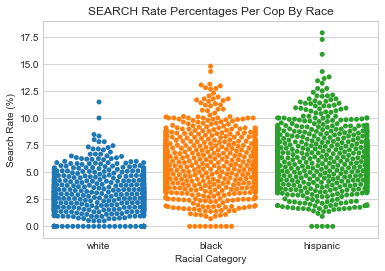

In [20]:
num_officers = len(np.array(cop_race_search_rates["white"])*100)
swarm_data = np.array([np.array(cop_race_search_rates["white"])*100,
                       np.array(cop_race_search_rates["black"])*100,
                       np.array(cop_race_search_rates["hispanic"])*100]).flatten()
swarm_labels = np.array([np.repeat('white',num_officers), np.repeat('black',num_officers),
                         np.repeat('hispanic',num_officers)]).flatten()
swarm_df = pd.DataFrame({'Search Rate (%)': swarm_data, 'Racial Category': swarm_labels})

sns.set_style("whitegrid")
ax = sns.swarmplot(x="Racial Category", y="Search Rate (%)", data=swarm_df)
plt.title("SEARCH Rate Percentages Per Cop By Race")

#plt.show()
plt.savefig('individual_search_rates.png')


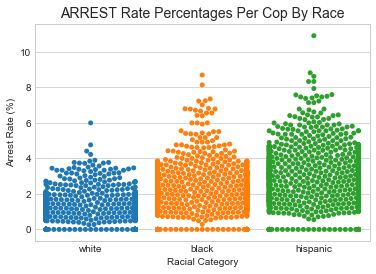

In [23]:
num_officers = len(np.array(cop_race_arrest_rates["white"])*100)
swarm_data = np.array([np.array(cop_race_arrest_rates["white"])*100,
                       np.array(cop_race_arrest_rates["black"])*100,
                       np.array(cop_race_arrest_rates["hispanic"])*100]).flatten()
swarm_labels = np.array([np.repeat('white',num_officers), np.repeat('black',num_officers),
                         np.repeat('hispanic',num_officers)]).flatten()
swarm_df = pd.DataFrame({'Arrest Rate (%)': swarm_data, 'Racial Category': swarm_labels})

sns.set_style("whitegrid")
ax = sns.swarmplot(x="Racial Category", y="Arrest Rate (%)", data=swarm_df)

plt.title("ARREST Rate Percentages Per Cop By Race", fontsize=14)
plt.savefig('individual_arrest_rates.png')


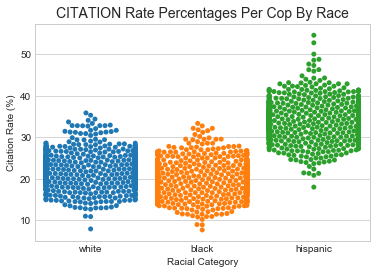

In [22]:
num_officers = len(np.array(cop_race_citation_rates["white"])*100)
swarm_data = np.array([np.array(cop_race_citation_rates["white"])*100,
                       np.array(cop_race_citation_rates["black"])*100,
                       np.array(cop_race_citation_rates["hispanic"])*100]).flatten()
swarm_labels = np.array([np.repeat('white',num_officers), np.repeat('black',num_officers),
                         np.repeat('hispanic',num_officers)]).flatten()
swarm_df = pd.DataFrame({'Citation Rate (%)': swarm_data, 'Racial Category': swarm_labels})

sns.set_style("whitegrid")
ax = sns.swarmplot(x="Racial Category", y="Citation Rate (%)", data=swarm_df)

plt.title("CITATION Rate Percentages Per Cop By Race", fontsize=14)

plt.savefig('individual_citation_rates.png')


(804, 3)


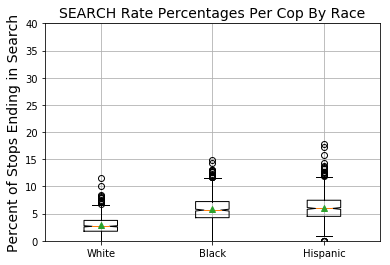

In [68]:
# Plot Search rates for each cop per race #

boxplt_array = np.transpose(np.vstack([np.array(cop_race_search_rates["white"])*100,
                            np.array(cop_race_search_rates["black"])*100,
                            np.array(cop_race_search_rates["hispanic"])*100]))
print(boxplt_array.shape)

plt.boxplot(boxplt_array, labels=["White", "Black", "Hispanic"], notch=True, showmeans=True)

plt.ylabel("Percent of Stops Ending in Search", fontsize=14)
plt.ylim([0,40])
plt.grid()
    
plt.title("SEARCH Rate Percentages Per Cop By Race", fontsize=14)

plt.savefig('individual_search_rates.png')


In [69]:
# Get standard deviations, skew, and means of Search rates for each race #
races_mod = ["white", "black", "hispanic"]
skewness = [skew(np.array(cop_race_search_rates[s])*100) for s in races_mod]
median = [np.median(np.array(cop_race_search_rates[s])*100) for s in races_mod]
mean = [np.mean(np.array(cop_race_search_rates[s])*100) for s in races_mod]
sd = [np.std(np.array(cop_race_search_rates[s])*100) for s in races_mod]

print("Median, Mean, SD, and Skewness for Percent of Stops Ending in Search for Each Race")
pd.DataFrame(np.vstack([median, mean, sd, skewness]), columns=["White", "Black", "Hispanic"],
            index=["Median", "Mean", "SD", "Skewness"])

Median, Mean, SD, and Skewness for Percent of Stops Ending in Search for Each Race


,White,Black,Hispanic
Median,2.663121,5.647450,5.952381
Mean,2.842551,5.783645,6.113232
SD,1.608151,2.348359,2.456217
Skewness,0.764716,0.382466,0.621429


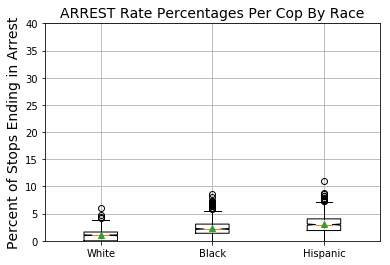

In [70]:
# Plot Arrest rates for each cop per race #

boxplt_array = np.transpose(np.vstack([np.array(cop_race_arrest_rates["white"])*100,
                            np.array(cop_race_arrest_rates["black"])*100,
                            np.array(cop_race_arrest_rates["hispanic"])*100]))

plt.boxplot(boxplt_array, labels=["White", "Black", "Hispanic"], notch=True, showmeans=True)

plt.ylabel("Percent of Stops Ending in Arrest", fontsize=14)
plt.ylim([0,40])
plt.grid()

plt.title("ARREST Rate Percentages Per Cop By Race", fontsize=14)

plt.savefig('individual_arrest_rates.png')



In [71]:
# Get standard deviations, skew, and means of Arrest rates for each race #
races_mod = ["white", "black", "hispanic"]
skewness = [skew(np.array(cop_race_arrest_rates[s])*100) for s in races_mod]
median = [np.median(np.array(cop_race_arrest_rates[s])*100) for s in races_mod]
mean = [np.mean(np.array(cop_race_arrest_rates[s])*100) for s in races_mod]
sd = [np.std(np.array(cop_race_arrest_rates[s])*100) for s in races_mod]

print("Median, Mean, SD, and Skewness for Percent of Stops Ending in Arrest for Each Race")
pd.DataFrame(np.vstack([median, mean, sd, skewness]), columns=["White", "Black", "Hispanic"],
            index=["Median", "Mean", "SD", "Skewness"])

Median, Mean, SD, and Skewness for Percent of Stops Ending in Arrest for Each Race


,White,Black,Hispanic
Median,1.017818,2.175305,2.985075
Mean,1.084825,2.268076,3.067200
SD,0.949711,1.412874,1.634962
Skewness,0.910492,0.788345,0.563160


(804, 3)


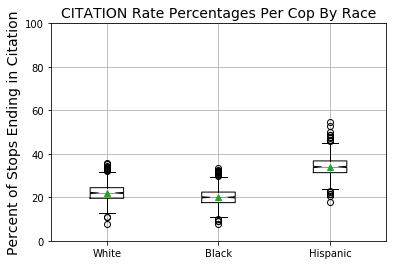

In [72]:
# Plot Citation rates for each cop per race #

boxplt_array = np.transpose(np.vstack([np.array(cop_race_citation_rates["white"])*100,
                            np.array(cop_race_citation_rates["black"])*100,
                            np.array(cop_race_citation_rates["hispanic"])*100]))
print(boxplt_array.shape)

plt.boxplot(boxplt_array, labels=["White", "Black", "Hispanic"], notch=True, showmeans=True)

plt.ylabel("Percent of Stops Ending in Citation", fontsize = 14)
plt.ylim([0,100])
plt.grid()

plt.title("CITATION Rate Percentages Per Cop By Race", fontsize = 14)

plt.savefig('individual_citation_rates.png')



In [73]:
# Get standard deviations, skew, and means of Citation rates for each race #
races_mod = ["white", "black", "hispanic"]
skewness = [skew(np.array(cop_race_citation_rates[s])*100) for s in races_mod]
median = [np.median(np.array(cop_race_citation_rates[s])*100) for s in races_mod]
mean = [np.mean(np.array(cop_race_citation_rates[s])*100) for s in races_mod]
sd = [np.std(np.array(cop_race_citation_rates[s])*100) for s in races_mod]

print("Median, Mean, SD, and Skewness for Percent of Stops Ending in Citation for Each Race")
pd.DataFrame(np.vstack([median, mean, sd, skewness]), columns=["White", "Black", "Hispanic"],
            index=["Median", "Mean", "SD", "Skewness"])



Median, Mean, SD, and Skewness for Percent of Stops Ending in Citation for Each Race


,White,Black,Hispanic
Median,21.986547,20.000000,33.976206
Mean,22.018421,20.031461,34.083703
SD,3.916894,3.854319,4.467599
Skewness,0.231715,0.209236,0.217796


In [16]:
## NOTES ##
"""
_______________________________________
Total Stops
2010: 310622
2011: 393248
2012: 444146
2013: 412695
2014: 413114
2015: 357261
2016: 297248
2017: 245565
2018: 204217
2019: 14235
_____________________________________
TOTALS:
Total vehicular stops white: 1,670,873
Percent of white stops resulting in arrest: 0.0109
Percent of white stops resulting in citation: 0.2195

Total vehicular stops black: 1,165,871
Percent of black stops resulting in arrest: 0.0226
Percent of black stops resulting in citation: 0.2019

Total vehicular stops hispanic: 164,814
Percent of hispanic stops resulting in arrest: 0.0311
Percent of hispanic stops resulting in citation: 0.3425

Total vehicular stops asian/pacific islander: 41,668
Percent of asian/pacific islander stops resulting in arrest: 0.0071
Percent of asian/pacific islander stops resulting in citation: 0.1912

Total vehicular stops unknown: 36,878
Percent of unknown stops resulting in arrest: 0.0054
Percent of unknown stops resulting in citation: 0.2882

Total vehicular stops other: 10,397
Percent of other stops resulting in arrest: 0.0088
Percent of other stops resulting in citation: 0.3049

____________________________________
outcome: arrest, citation, warning

reasons for stop: 'child restraint', 'investigative stop',
       'moving traffic violation', 'parking violation', 'registration',
       'safety violation', 'seatbelt violation',
       'vehicle equipment violation'
       
violation: same as reasons for stop

search basis: consent, other, plain view, probable cause

type: vehicular (ALL ARE VEHICULAR STOPS)
____________________________________________

Code for seaborn plots if needed
'''
num_officers = len(np.array(search_rates_per_cop_dict["white"])*100)
swarm_data = np.array([np.array(search_rates_per_cop_dict["white"])*100,
                       np.array(search_rates_per_cop_dict["black"])*100,
                       np.array(search_rates_per_cop_dict["hispanic"])*100]).flatten()
swarm_labels = np.array([np.repeat('white',num_officers), np.repeat('black',num_officers),
                         np.repeat('hispanic',num_officers)]).flatten()
swarm_df = pd.DataFrame({'Search Rate (%)': swarm_data, 'Racial Category': swarm_labels})
'''

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-16-772a207d3787>, line 54)